In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

In [38]:
# Trae la base de datos 
heart_disease = fetch_ucirepo(id=45)  
  
# variable information 
print(heart_disease.variables) 

# Combinarlos
df = heart_disease.data.original.copy()

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

In [39]:
# Data frame
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [41]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

revisamos cuanto reprecentan los datos faltantes en la base de datos

In [42]:
(df.isnull().sum() * 100) / 302

age         0.000000
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.000000
fbs         0.000000
restecg     0.000000
thalach     0.000000
exang       0.000000
oldpeak     0.000000
slope       0.000000
ca          1.324503
thal        0.662252
num         0.000000
dtype: float64

## Variables cuantitativas 
<ul>
    <li>age</li>
    <li>trestbps (resting blood pressure) </li>
    <li>chol (serum cholestoral)</li>
    <li>thalach (maximum heart rate achieved)</li>
    <li>oldpeak (ST depression induced by exercise relative to rest)</li>
</ul>

## Variables cualitativas
<ul>
    <li>sex</li>
    <li>cp (chest pain)</li>
    <li>fbs (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)</li>
    <li>restecg (resting electrocardiographic results)</li>
    <li>exang (exercise induced angina) (1 = yes; 0 = no)</li>
    <li>slope (the slope of the peak exercise ST segment)</li>
    <li>thal (3 = normal; 6 = fixed defect; 7 = reversable defect)</li>
    <li>ca (number of major vessels (0-3) colored by flourosopy)</li>
</ul>


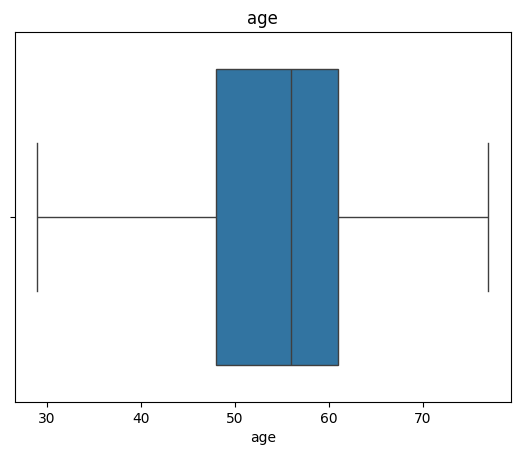

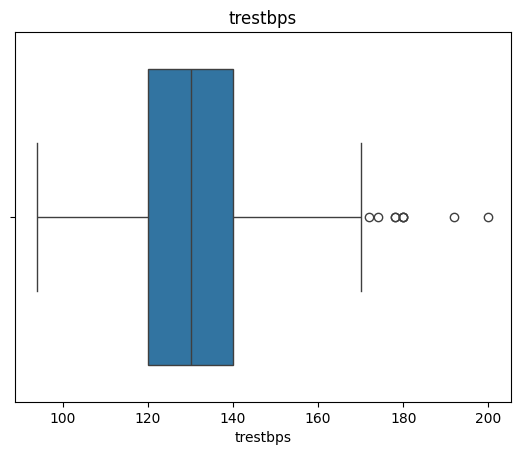

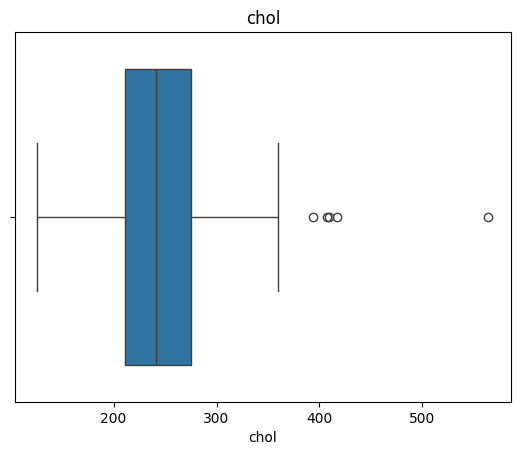

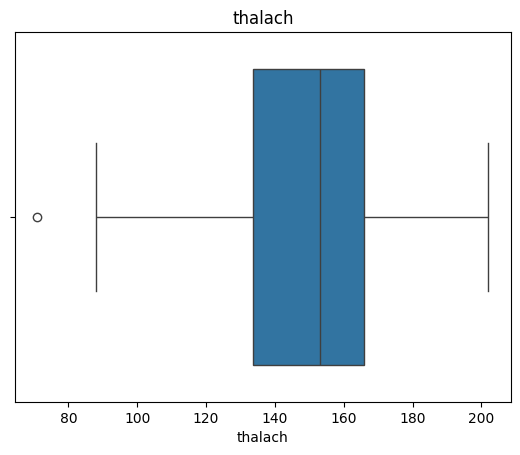

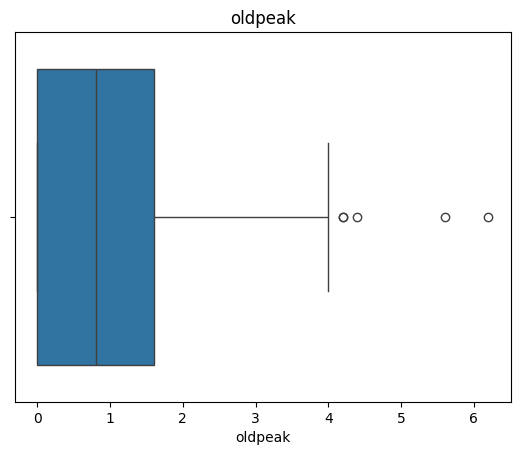

In [43]:
# Poner las variables categorícas como object
categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal', 'slope']
df[categoricas] = df[categoricas].astype(object)

# separar las variables numericas
cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Muestra el boxplot de cada una de las variables
for col in cols:
    sns.boxplot(x=col, data = df)
    plt.title(col)
    plt.show()

Usamos los boxplots para identificar los outliers de cada una de las variables

## Datos faltantes

Las unicas variables que presentan datos faltantes son ca y thal, como estos representan menos del 5 porciento del total de los datos podemos imputar los datos faltantes

In [44]:
df = df.dropna()
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [45]:
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    print(f'{col}: {df[(df[col] < lim_inf) | (df[col] > lim_sup)].shape[0]} outliers')
    if col == 'oldpeak':
        # trata oldpeak con clip (se trata aca por que se necesitan los limites del boxplot)
        df[col] = df[col].clip(lim_inf, lim_sup)

age: 0 outliers
trestbps: 9 outliers
chol: 5 outliers
thalach: 1 outliers
oldpeak: 5 outliers


/var/folders/pp/g422ndkj1fjg2n3svfwh2l4w0000gn/T/ipykernel_4026/558505138.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].clip(lim_inf, lim_sup)


In [46]:
df['trestbps'] = winsorize(df['trestbps'], limits=[0.05, 0.05])
df['chol'] = winsorize(df['chol'], limits=[0.05, 0.05])
df['thalach'] = winsorize(df['thalach'], limits=[0.05, 0.05])
df['ca'] = winsorize(df['thalach'], limits=[0.05, 0.05])

/var/folders/pp/g422ndkj1fjg2n3svfwh2l4w0000gn/T/ipykernel_4026/308335225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trestbps'] = winsorize(df['trestbps'], limits=[0.05, 0.05])
/var/folders/pp/g422ndkj1fjg2n3svfwh2l4w0000gn/T/ipykernel_4026/308335225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chol'] = winsorize(df['chol'], limits=[0.05, 0.05])
/var/folders/pp/g422ndkj1fjg2n3svfwh2l4w0000gn/T/ipykernel_4026/308335225.py:3: SettingWithCopyWarning: 
A value is trying to be set on a co

In [47]:
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    print(f'{col}: {df[(df[col] < lim_inf) | (df[col] > lim_sup)].shape[0]} outliers')

age: 0 outliers
trestbps: 0 outliers
chol: 0 outliers
thalach: 0 outliers
oldpeak: 0 outliers


/Users/sebastiansanchez/.pyenv/versions/3.12.2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/sebastiansanchez/.pyenv/versions/3.12.2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/sebastiansanchez/.pyenv/versions/3.12.2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/sebastiansanchez/.pyenv/versions/3.12.2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/sebastiansanchez/.pyenv/versions/3.12.2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the

In [48]:
cat_cols = df.select_dtypes(include=['object']).columns
print("Variables categóricas:", list(cat_cols))

# Aplicar One-Hot Encoding si hay categóricas
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop(columns='num')
y = df['num']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir de nuevo a DataFrame con nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Confirmar
print(" Preprocesamiento completo. Datos listos para modelar.")

Variables categóricas: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
 Preprocesamiento completo. Datos listos para modelar.


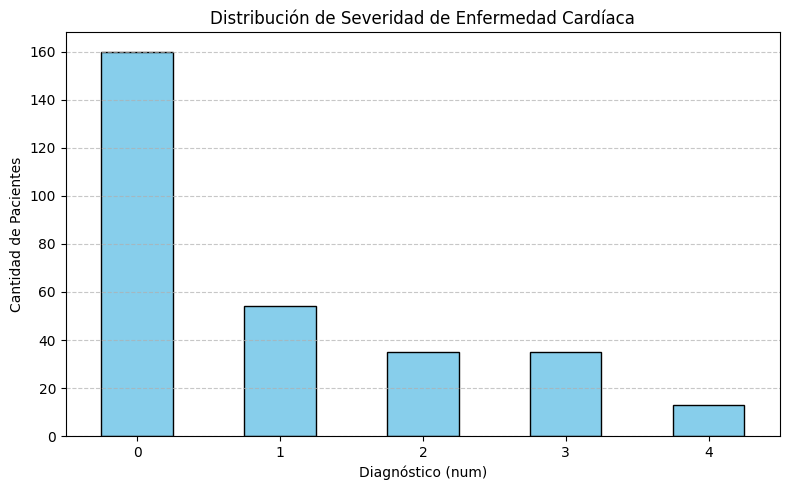

In [49]:
value_counts = df['num'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(8, 5))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribución de Severidad de Enfermedad Cardíaca')
plt.xlabel('Diagnóstico (num)')
plt.ylabel('Cantidad de Pacientes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

num
0    160
1    137
Name: count, dtype: int64


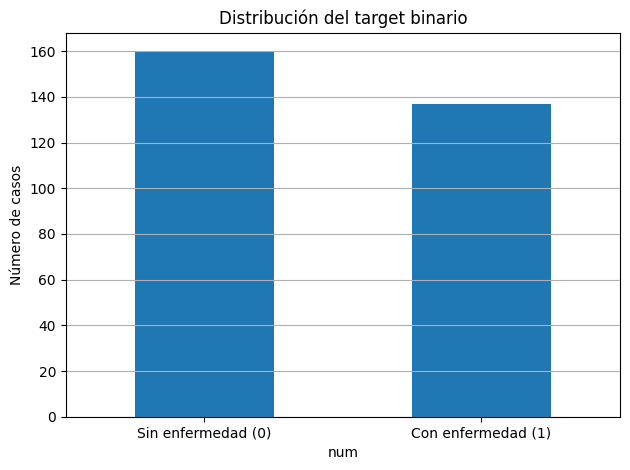

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
# Supongamos que ya recodificaste la variable
y = y.apply(lambda x: 1 if x > 0 else 0)

# Ver distribución
class_counts = y.value_counts()
print(class_counts)

# Diagrama de barras
class_counts.plot(kind='bar')
plt.title("Distribución del target binario")
plt.xticks([0, 1], ['Sin enfermedad (0)', 'Con enfermedad (1)'], rotation=0)
plt.ylabel("Número de casos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# SMOTE

In [51]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

Distribución de clases en y_smote:
num
0    160
1    160
Name: count, dtype: int64


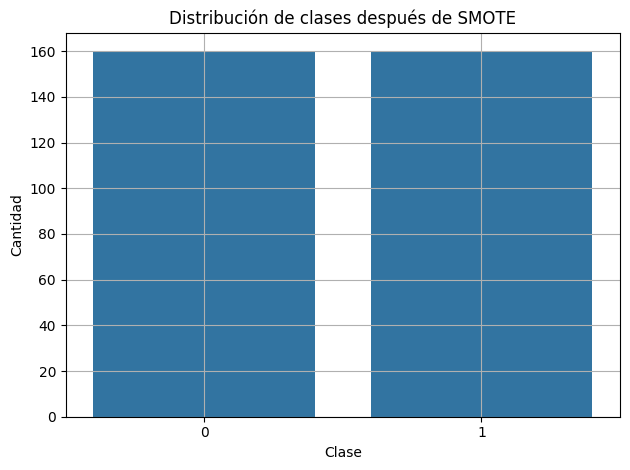

In [52]:
try:
    print("Distribución de clases en y_smote:")
    print(y_smote.value_counts())

    sns.countplot(x=y_smote)
    plt.title("Distribución de clases después de SMOTE")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
except NameError:
    print(" La variable 'y_smote' no existe. Asegúrate de haber ejecutado el bloque de SMOTE.")

# Undersampling

In [53]:
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

Distribución de clases en y_smote:
num
0    137
1    137
Name: count, dtype: int64


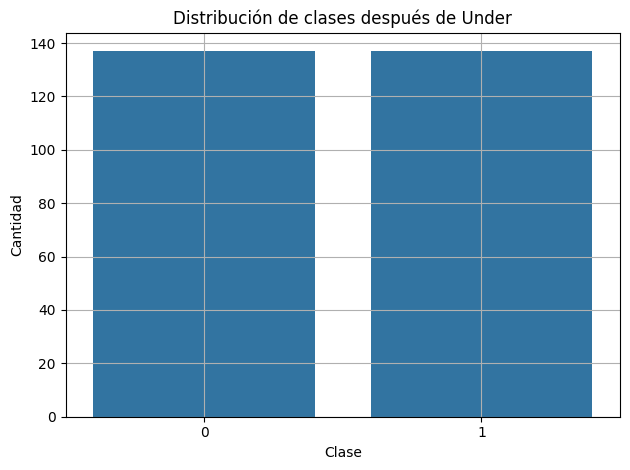

In [54]:
# Si ya aplicaste SMOTE, asegúrate de estar usando y_smote
try:
    print("Distribución de clases en y_smote:")
    print(y_under.value_counts())

    sns.countplot(x=y_under)
    plt.title("Distribución de clases después de Under")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
except NameError:
    print("La variable 'y_under' no existe.")

# Pipelines SMOTE
## Logistic regresion

Hold-Out
Accuracy: 0.7916666666666666


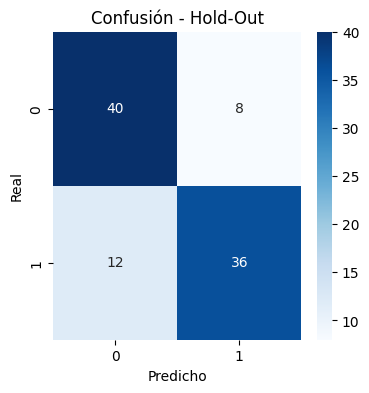

K-Fold
Accuracy: 0.796875


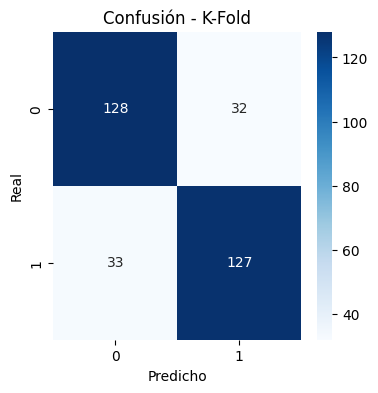

Stratified K-Fold
Accuracy: 0.790625


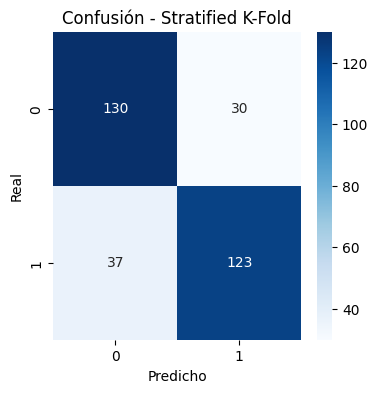

LOOCV (Leave-One-Out)
Accuracy: 0.790625


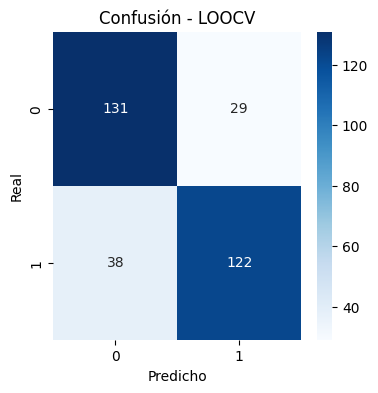

In [55]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, LeaveOneOut, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

print("Hold-Out")
# Dividir el dataset balanceado
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(
    X_smote, y_smote,
    test_size=0.30,
    stratify=y_smote,
    random_state=1
)

pipeline.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_holdout_SMOTE = pipeline.predict(X_test_SMOTE)
print("Accuracy:", accuracy_score(y_test_SMOTE, y_pred_holdout_SMOTE))
plot_confusion(y_test_SMOTE, y_pred_holdout_SMOTE, "Confusión - Hold-Out")

# 2. K-Fold
print("K-Fold")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_kf_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=kf)
print("Accuracy:", accuracy_score(y_smote, y_pred_kf_SMOTE))
plot_confusion(y_smote, y_pred_kf_SMOTE, "Confusión - K-Fold")

print("Stratified K-Fold")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_skf_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=skf)
print("Accuracy:", accuracy_score(y_smote, y_pred_skf_SMOTE))
plot_confusion(y_smote, y_pred_skf_SMOTE, "Confusión - Stratified K-Fold")

print("LOOCV (Leave-One-Out)")
loo = LeaveOneOut()
# Para ahorrar tiempo, podrías usar un subconjunto si tienes muchos datos:
# X_loo, y_loo = X[:100], y[:100]
y_pred_loo_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=loo)
print("Accuracy:", accuracy_score(y_smote, y_pred_loo_SMOTE))
plot_confusion(y_smote, y_pred_loo_SMOTE, "Confusión - LOOCV")

In [56]:
import pandas as pd

# Calcula los accuracy (ya lo tienes en tu código)
accuracy_holdout = accuracy_score(y_test_SMOTE, y_pred_holdout_SMOTE)
accuracy_kfold = accuracy_score(y_smote, y_pred_kf_SMOTE)
accuracy_stratkfold = accuracy_score(y_smote, y_pred_skf_SMOTE)
accuracy_loo = accuracy_score(y_smote, y_pred_loo_SMOTE)

# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    "Método": ["Hold-Out", "K-Fold", "Stratified K-Fold", "LOOCV"],
    "Accuracy": [accuracy_holdout, accuracy_kfold, accuracy_stratkfold, accuracy_loo]
})

# Mostrar la tabla ordenada de mayor a menor accuracy
print(resultados.sort_values(by="Accuracy", ascending=False).reset_index(drop=True))


              Método  Accuracy
0             K-Fold  0.796875
1           Hold-Out  0.791667
2  Stratified K-Fold  0.790625
3              LOOCV  0.790625


Como K-fold es el que mejor accuracy tiene es el que vamos a utilizar para analizar

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_smote, y_pred_kf_SMOTE))
print("Precision:", precision_score(y_smote, y_pred_kf_SMOTE))
print("Recall:", recall_score(y_smote, y_pred_kf_SMOTE))
print("F1-score:", f1_score(y_smote, y_pred_kf_SMOTE))

Accuracy: 0.796875
Precision: 0.7987421383647799
Recall: 0.79375
F1-score: 0.7962382445141066


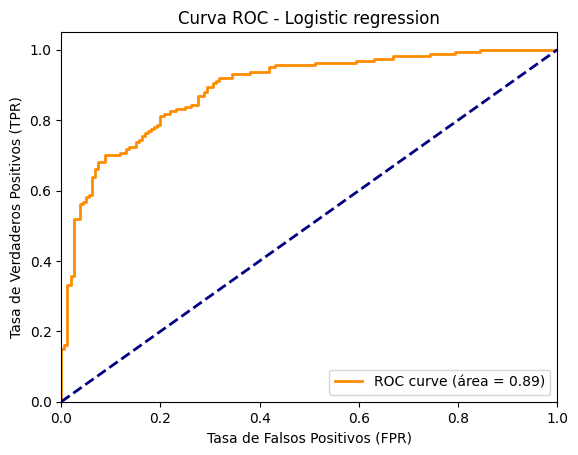

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# Obtenemos las probabilidades predichas para la clase positiva (por ejemplo, clase 1)
y_prob_kf_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=kf, method='predict_proba')[:, 1]

# Calculamos FPR, TPR y thresholds para la curva ROC
fpr, tpr, thresholds = roc_curve(y_smote, y_prob_kf_SMOTE)

# Calculamos el AUC (Area Under Curve)
roc_auc = roc_auc_score(y_smote, y_prob_kf_SMOTE)

# Graficamos la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal para referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Logistic regression')
plt.legend(loc="lower right")
plt.show()

## SVM

Hold-Out
Accuracy: 0.8229166666666666


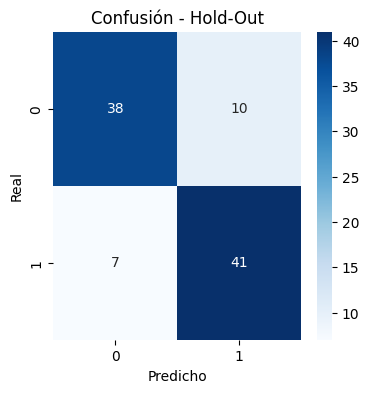

K-Fold
Accuracy: 0.81875


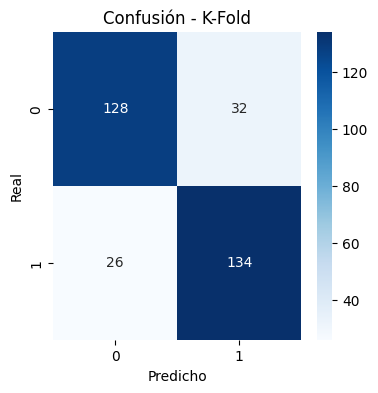

Stratified K-Fold
Accuracy: 0.790625


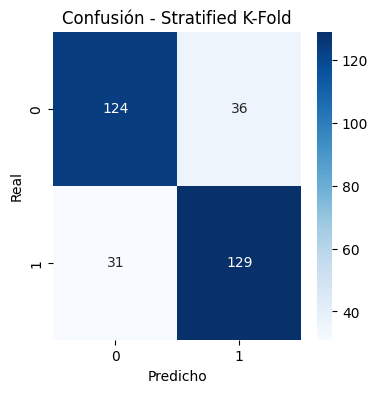

LOOCV (Leave-One-Out)
Accuracy: 0.803125


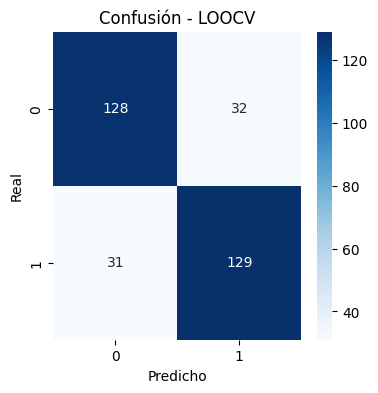

In [59]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

print("Hold-Out")
# Dividir el dataset balanceado
X_train_SMOTE, X_test_SMOTE, y_train_SMOTE, y_test_SMOTE = train_test_split(
    X_smote, y_smote,
    test_size=0.30,
    stratify=y_smote,
    random_state=1
)

pipeline.fit(X_train_SMOTE, y_train_SMOTE)
y_pred_holdout_SMOTE = pipeline.predict(X_test_SMOTE)
print("Accuracy:", accuracy_score(y_test_SMOTE, y_pred_holdout_SMOTE))
plot_confusion(y_test_SMOTE, y_pred_holdout_SMOTE, "Confusión - Hold-Out")

# 2. K-Fold
print("K-Fold")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_kf_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=kf)
print("Accuracy:", accuracy_score(y_smote, y_pred_kf_SMOTE))
plot_confusion(y_smote, y_pred_kf_SMOTE, "Confusión - K-Fold")

print("Stratified K-Fold")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_skf_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=skf)
print("Accuracy:", accuracy_score(y_smote, y_pred_skf_SMOTE))
plot_confusion(y_smote, y_pred_skf_SMOTE, "Confusión - Stratified K-Fold")

print("LOOCV (Leave-One-Out)")
loo = LeaveOneOut()
# Para ahorrar tiempo, podrías usar un subconjunto si tienes muchos datos:
# X_loo, y_loo = X[:100], y[:100]
y_pred_loo_SMOTE = cross_val_predict(pipeline, X_smote, y_smote, cv=loo)
print("Accuracy:", accuracy_score(y_smote, y_pred_loo_SMOTE))
plot_confusion(y_smote, y_pred_loo_SMOTE, "Confusión - LOOCV")

In [60]:
accuracy_holdout = accuracy_score(y_test_SMOTE, y_pred_holdout_SMOTE)
accuracy_kfold = accuracy_score(y_smote, y_pred_kf_SMOTE)
accuracy_stratkfold = accuracy_score(y_smote, y_pred_skf_SMOTE)
accuracy_loo = accuracy_score(y_smote, y_pred_loo_SMOTE)

# Crear un DataFrame con los resultados
resultados = pd.DataFrame({
    "Método": ["Hold-Out", "K-Fold", "Stratified K-Fold", "LOOCV"],
    "Accuracy": [accuracy_holdout, accuracy_kfold, accuracy_stratkfold, accuracy_loo]
})

# Mostrar la tabla ordenada de mayor a menor accuracy
print(resultados.sort_values(by="Accuracy", ascending=False).reset_index(drop=True))

              Método  Accuracy
0           Hold-Out  0.822917
1             K-Fold  0.818750
2              LOOCV  0.803125
3  Stratified K-Fold  0.790625


Como K-fold es el que mejor accuracy tiene es el que vamos a utilizar para analizar

In [61]:
print("Accuracy:", accuracy_score(y_test_SMOTE, y_pred_holdout_SMOTE))
print("Precision:", precision_score(y_test_SMOTE, y_pred_holdout_SMOTE))
print("Recall:", recall_score(y_test_SMOTE, y_pred_holdout_SMOTE))
print("F1-score:", f1_score(y_test_SMOTE, y_pred_holdout_SMOTE))


Accuracy: 0.8229166666666666
Precision: 0.803921568627451
Recall: 0.8541666666666666
F1-score: 0.8282828282828283


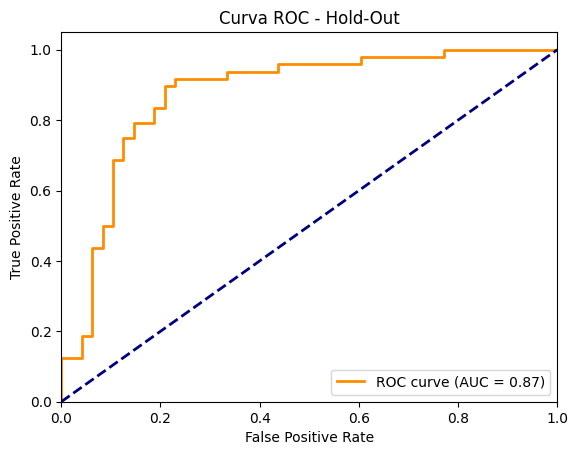

In [62]:
y_prob_holdout_SMOTE = pipeline.predict_proba(X_test_SMOTE)[:, 1]

# Calcula los valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_SMOTE, y_prob_holdout_SMOTE)

# Calcula el AUC
roc_auc = roc_auc_score(y_test_SMOTE, y_prob_holdout_SMOTE)

# Grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Hold-Out')
plt.legend(loc="lower right")
plt.show()